# State-based dynamic functional connectivity for continuously varying measures

The previous tutorials showed how to (1) estimate continuously varying dFC measures and (2) work with inherently state-based measures. However, Comet also allows users to perform clustering analysis on continuous measures.

We can simply use the same example as before to derive state measures for a single subject:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from nilearn import datasets
from comet import connectivity, utils


# Preprocessed time series data from the ABIDE dataset
subject = 50010
data = datasets.fetch_abide_pcp(SUB_ID=subject, pipeline='cpac', band_pass_filtering=True, derivatives="rois_dosenbach160")
ts = data.rois_dosenbach160[0]

sw = connectivity.SlidingWindow(ts)
dfc_sw = sw.estimate()

/home/mibur/miniconda3/envs/dfc-multiverse/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


[fetch_abide_pcp] Dataset found in /home/mibur/nilearn_data/ABIDE_pcp

Next, we can perform clustering analysis and extract some summary measures:

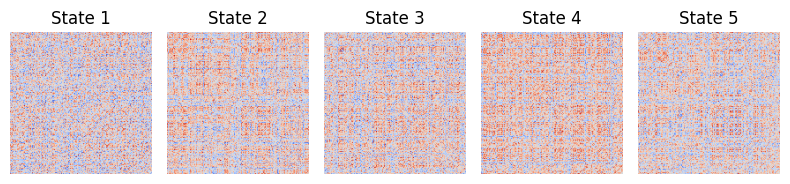

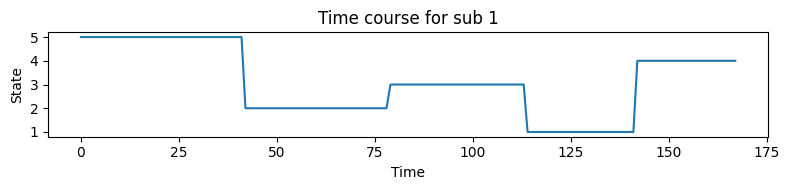

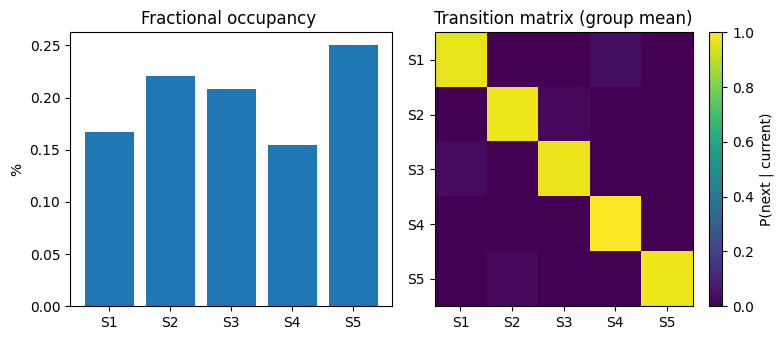

In [2]:
state_tc, states, inertia = utils.kmeans_cluster(dfc_sw, num_states=5, random_state=0)
summary = utils.summarise_state_tc(state_tc)

fig1, ax1 = utils.state_plots(states=states, figsize=(8,2))
fig2, ax2 = utils.state_plots(state_tc=state_tc, figsize=(8,2))
fig3, ax3 = utils.state_plots(summary=summary, figsize=(8,3.5))

More commonly, state-based analysis uses multiple subjects for estimating the state dynamics. For this, we can simply estimate dFC for multiple subjects and store the estimates in a list before performing the clustering analysis:

In [4]:
# Get data from 5 subjects
subjects = ["50008", "50010", "50012", "50014", "50020"]
data = datasets.fetch_abide_pcp(SUB_ID=subjects, pipeline='cpac', band_pass_filtering=True, derivatives="rois_dosenbach160")
ts = data.rois_dosenbach160 # list of 2D time series data

print("Number of subjects:",len(ts))
print("Tme series shape:", ts[0].shape)

# Estimate dFC for all subjects and store as a list
dfc_list = []

for sub_ts in ts:
    dfc = connectivity.LeiDA(sub_ts).estimate()
    dfc_list.append(dfc)

[fetch_abide_pcp] Dataset found in /home/mibur/nilearn_data/ABIDE_pcp

Number of subjects: 5
Tme series shape: (196, 161)


You can then estimate state dynamics. For popular summary metrics, the `summarise_state_tc` and `state_plots` functions are available:

Average transition matrix:
[[0.70986301 0.11048924 0.02444444 0.15246358 0.00273973]
 [0.05535736 0.86545362 0.02090571 0.03159148 0.02669184]
 [0.03783221 0.06726944 0.69489835 0.         0.        ]
 [0.04308123 0.0955343  0.02       0.8043024  0.03708207]
 [0.00540541 0.04621622 0.1        0.03581081 0.61256757]]


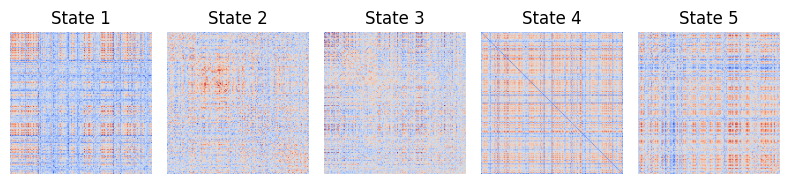

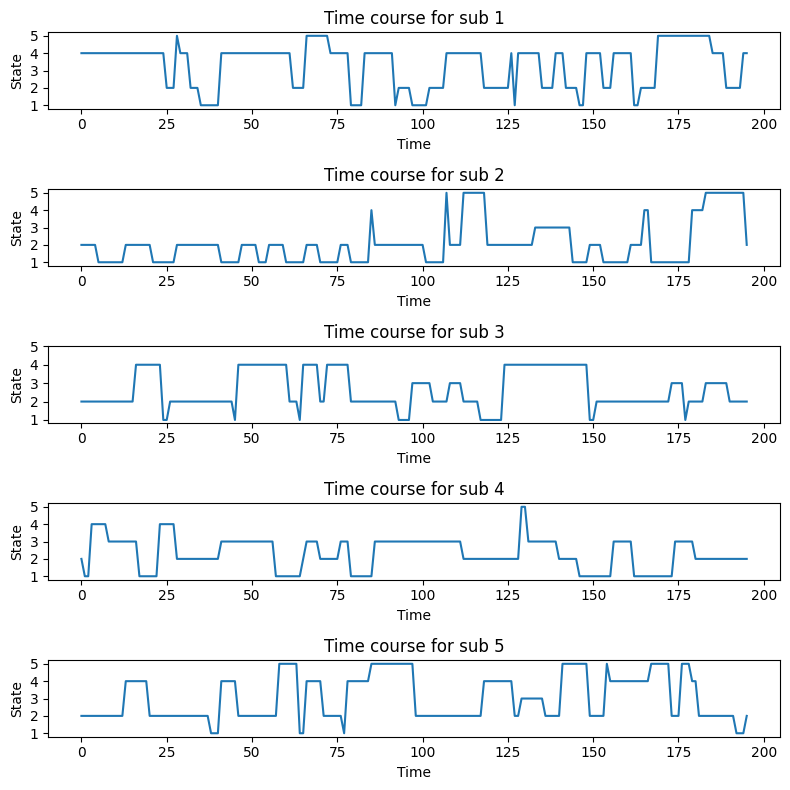

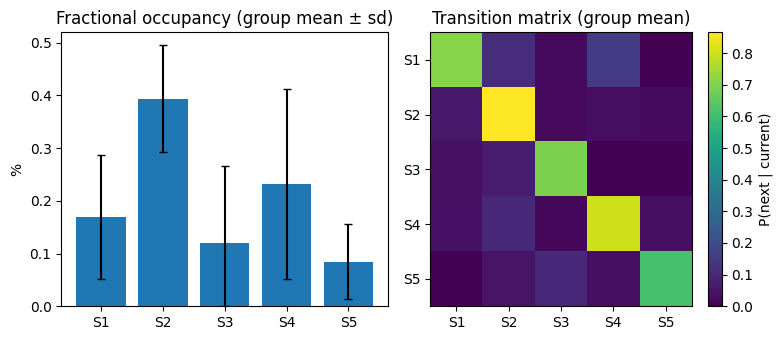

In [6]:
state_tc, states, inertia = utils.kmeans_cluster(dfc_list, strategy="pooled")
summary = utils.summarise_state_tc(state_tc)

print("Average transition matrix:")
print(summary["transitions"].mean(axis=0))

# Plot results
fig1, ax1 = utils.state_plots(states=states, figsize=(8,2))
fig2, ax2 = utils.state_plots(state_tc=state_tc, figsize=(8,8))
fig3, ax3 = utils.state_plots(summary=summary, figsize=(8,3.5))

The attentive reader might have noticed that there is the normal `SlidingWindow` class as well as the `SlidingWindowClustering` class for the state-based method. And in fact, these two classes will produce the same results:

In [11]:
# SlidingWindow()
"""dfc_list = []
for sub_ts in ts:
    dfc_sw = connectivity.SlidingWindow(sub_ts, shape="gaussian").estimate()
    dfc_list.append(dfc)"""

# Data
subject = 50010
data = datasets.fetch_abide_pcp(SUB_ID=subject, pipeline='cpac', band_pass_filtering=True, derivatives="rois_dosenbach160")
ts = data.rois_dosenbach160[0]

dfc_sw = connectivity.SlidingWindow(ts, shape="gaussian").estimate()
state_tc, states, inertia = utils.kmeans_cluster(dfc_sw, strategy="two_level")

# SlidingWindowClustering()
state_tc_swc, states_swc = connectivity.SlidingWindowClustering(ts, stepsize=1).estimate()

[fetch_abide_pcp] Dataset found in /home/mibur/nilearn_data/ABIDE_pcp

Sliding Window Clustering: 100%|██████████| 1/1 [00:43<00:00, 43.37s/it]


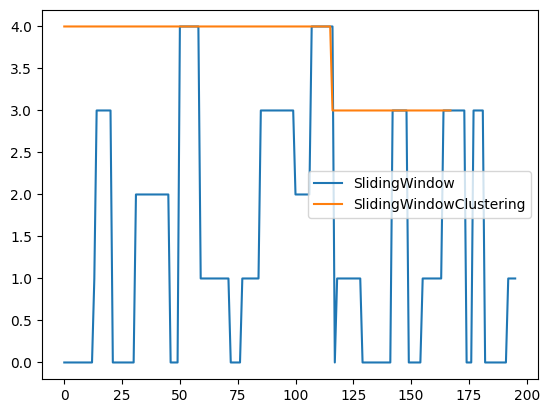

In [9]:
fig, ax = plt.subplots()
ax.plot(state_tc[0], label="SlidingWindow")
ax.plot(state_tc_swc[0], label="SlidingWindowClustering")
plt.legend();